In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
df = pd.read_csv('alipur,-delhi, delhi, india-air-quality.csv', parse_dates=['date'])  
df.index = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [6]:
numeric_columns = [' o3', ' pm25', ' pm10', ' no2', ' so2', ' co']
non_numeric_values = df[numeric_columns].apply(lambda x: pd.to_numeric(x, errors='coerce')).isnull().sum()

df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [7]:
df.ffill(inplace=True)

In [8]:
df.tail()

,pm25,pm10,o3,no2,so2,co
date,,,,,,
2024-01-23,339,181.0,53.0,21.0,13.0,5.0
2024-01-24,379,312.0,19.0,48.0,15.0,11.0
2024-01-25,366,71.0,35.0,21.0,13.0,2.0
2024-01-26,302,157.0,23.0,29.0,12.0,5.0
2024-01-27,232,157.0,32.0,6.0,5.0,14.0


In [9]:
for col in df.columns:
    
    # ADF test
    result = adfuller(df[col])  
    if result[1] > 0.05:
        print(f"{col} is non-stationary")
        
    else:
        print(f"{col} is stationary")

 pm25 is stationary
 pm10 is stationary
 o3 is stationary
 no2 is stationary
 so2 is stationary
 co is stationary


In [13]:
exog_cols = [' pm25', ' pm10', ' no2', ' so2', ' co']
train_size = int(len(df) * 0.95)
train, test = df[:train_size], df[train_size:]

In [11]:
#??????????????????????
scp = pm.auto_arima(train[' o3'], seasonal=True, m=7, 
                    start_p=0, max_p=3, start_q=0, max_q=3,
                    start_P=0, max_P=3, start_Q=0, max_Q=3, 
                    start_d=0, max_d=3, D=1, max_D=3, 
                    trace=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=15873.654, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=14858.226, Time=0.70 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=14770.798, Time=1.23 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=15871.675, Time=0.04 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=15447.227, Time=0.30 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=14740.508, Time=4.27 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=10.23 sec
 ARIMA(0,0,1)(0,1,3)[7] intercept   : AIC=inf, Time=9.68 sec
 ARIMA(0,0,1)(1,1,3)[7] intercept   : AIC=inf, Time=21.02 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=15320.025, Time=2.09 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=10.80 sec
 ARIMA(0,0,2)(0,1,2)[7] intercept   : AIC=inf, Time=5.74 sec
 ARIMA(1,0,0)(0,1,2)[7] intercept   : AIC=inf, Time=6.33 sec
 ARIMA(1,0,2)(0,1,2)[7] intercept   : AIC=inf, Time=12.06 

In [14]:
sarimax_model = SARIMAX(train[' o3'], exog=train[exog_cols], order=(0, 0, 1), seasonal_order=(0, 1, 2, 7), trend='ct')
sarimax_results = sarimax_model.fit(disp=False)

/home/aks/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aks/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [682]:
#sarimax_model = SARIMAX(seasonal, exog=train[exog_cols], order=(2, 0, 1), seasonal_order=(3, 1, 0, 7))
#sarimax_seasonal_results = sarimax_model.fit(disp=False)

In [15]:
sarimax_pred = sarimax_results.get_forecast(steps=len(test), exog=test[exog_cols])
#sarimax_seasonal_pred = sarimax_seasonal_results.get_forecast(steps=len(test), exog=test[exog_cols])

/home/aks/.local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [16]:
#trend_pred = sarimax_trend_pred.predicted_mean
#seasonal_pred = sarimax_seasonal_pred.predicted_mean

sarimax_pred_mean = sarimax_pred.predicted_mean


In [17]:
sarimax_pred_mean.index

RangeIndex(start=1781, stop=1875, step=1)

In [18]:
sarimax_pred_mean.index = test.index

In [19]:
test.index

DatetimeIndex(['2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29',
               '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02',
               '2023-11-03', '2023-11-04', '2023-11-05', '2023-11-06',
               '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-10',
               '2023-11-11', '2023-11-12', '2023-11-13', '2023-11-14',
               '2023-11-15', '2023-11-16', '2023-11-17', '2023-11-18',
               '2023-11-19', '2023-11-20', '2023-11-21', '2023-11-22',
               '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-09', '2023-12-10', '2023-12-11', '2023-12-12',
               '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-16',
               '2023-12-17', '2023-12-18', '2023-12-19', '2023-12-20',
      

In [20]:
sarimax_pred_mean.index

DatetimeIndex(['2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29',
               '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02',
               '2023-11-03', '2023-11-04', '2023-11-05', '2023-11-06',
               '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-10',
               '2023-11-11', '2023-11-12', '2023-11-13', '2023-11-14',
               '2023-11-15', '2023-11-16', '2023-11-17', '2023-11-18',
               '2023-11-19', '2023-11-20', '2023-11-21', '2023-11-22',
               '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-09', '2023-12-10', '2023-12-11', '2023-12-12',
               '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-16',
               '2023-12-17', '2023-12-18', '2023-12-19', '2023-12-20',
      

In [21]:
sarimax_pred_hourly = np.repeat(sarimax_pred_mean.values, 24)

In [22]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(sarimax_pred_hourly.reshape(-1, 1))

In [23]:
sequence_length = 10
x, y = [], []
for i in range(len(scaled_data) - sequence_length):
    x.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[i + sequence_length])

x, y = np.array(x), np.array(y)

In [24]:
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [25]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x, y, epochs=17, batch_size=32)

Epoch 1/17
71/71 [==============================] - 3s 10ms/step - loss: 0.0268
Epoch 2/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0047
Epoch 3/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0044
Epoch 4/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0041
Epoch 5/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0039
Epoch 6/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0037
Epoch 7/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0032
Epoch 8/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0030
Epoch 9/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0028
Epoch 10/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0025
Epoch 11/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 12/17
71/71 [==============================] - 1s 9ms/step - loss: 0.0029
Epoch 13/17
71/71 [=============================

In [26]:
future_hours = 12  # Number of hours to predict
input_sequence = scaled_data[-sequence_length:].reshape(1, -1, 1)

In [27]:
lstm_preds = []
for _ in range(future_hours):
    lstm_pred = lstm_model.predict(input_sequence)
    lstm_preds.append(lstm_pred[0, 0])
    input_sequence = np.append(input_sequence[:, 1:, :], lstm_pred.reshape(1, 1, 1), axis=1)

1/1 [==============================] - 0s 16ms/step


In [28]:
lstm_preds = scaler.inverse_transform(np.array(lstm_preds).reshape(-1, 1))

In [29]:
lstm_preds

array([[17.43443 ],
       [17.471281],
       [17.521244],
       [17.576956],
       [17.634958],
       [17.693518],
       [17.751715],
       [17.808983],
       [17.864927],
       [17.919252],
       [17.971708],
       [18.02485 ]], dtype=float32)

In [30]:
test.index

DatetimeIndex(['2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29',
               '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02',
               '2023-11-03', '2023-11-04', '2023-11-05', '2023-11-06',
               '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-10',
               '2023-11-11', '2023-11-12', '2023-11-13', '2023-11-14',
               '2023-11-15', '2023-11-16', '2023-11-17', '2023-11-18',
               '2023-11-19', '2023-11-20', '2023-11-21', '2023-11-22',
               '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04',
               '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08',
               '2023-12-09', '2023-12-10', '2023-12-11', '2023-12-12',
               '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-16',
               '2023-12-17', '2023-12-18', '2023-12-19', '2023-12-20',
      

In [31]:
pd.DataFrame(lstm_preds, pd.date_range(start=test.index.max(), periods=future_hours, freq='H'))

,0
2024-01-27 00:00:00,17.434429
2024-01-27 01:00:00,17.471281
2024-01-27 02:00:00,17.521244
2024-01-27 03:00:00,17.576956
2024-01-27 04:00:00,17.634958
2024-01-27 05:00:00,17.693518
2024-01-27 06:00:00,17.751715
2024-01-27 07:00:00,17.808983
2024-01-27 08:00:00,17.864927
2024-01-27 09:00:00,17.919252


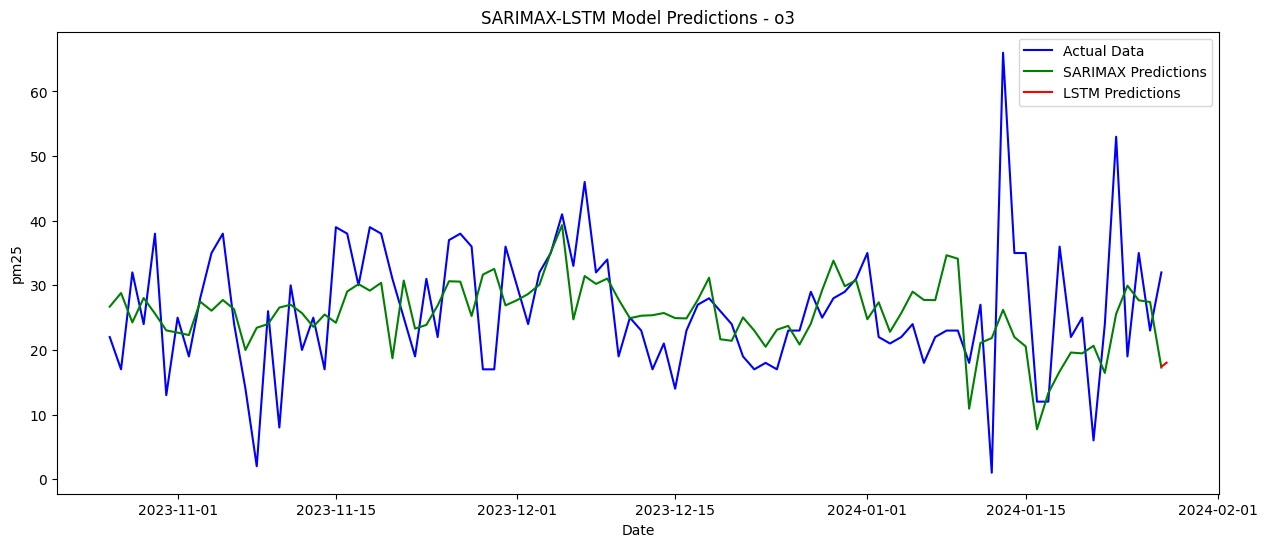

In [32]:
plt.figure(figsize=(15, 6))
#plt.plot(train.index, train[' o3'], label='Train data', color='blue')
plt.plot(test.index, test[' o3'], label='Actual Data', color='blue')
plt.plot(sarimax_pred_mean.index, sarimax_pred_mean.values, label='SARIMAX Predictions', color='green')
plt.plot(pd.date_range(start=test.index.max(), periods=future_hours, freq='H'), lstm_preds, label='LSTM Predictions', color='red')
plt.legend()
plt.title('SARIMAX-LSTM Model Predictions - o3')
plt.xlabel('Date')
plt.ylabel('pm25')
plt.show()

In [34]:
rmse = mean_squared_error(test[' o3'], sarimax_pred_mean.values)
rmse**0.5

9.732986401754122